In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import time
import glob
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer

/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Read in master dataset

In [33]:
data = pd.read_csv('../../yelp-data/data.csv')

In [21]:
data.head()

,AcceptsCreditCards,AgesAllowed,Alcohol,Attire,BYOB/Corkage,Caters,Delivery,DietaryRestrictions,DogsAllowed,Drive-Thru,...,biz_type,date,review_id,stars,text,type,user_id,votes_cool,votes_funny,votes_useful
0,True,NaN,full_bar,casual,NaN,True,False,NaN,NaN,NaN,...,business,2012-08-06,IhLPy_qJqRyGb_vGwHNeaQ,4,We decided on Sapporo after reading so-so revi...,review,e6GiLUdbUaPX7-P9QtHrXg,0.0,0.0,1.0
1,True,NaN,full_bar,casual,NaN,True,False,NaN,NaN,NaN,...,business,2013-04-22,qUkI_rNF-xpaQXqvdpb1hg,5,I travel a lot and have eaten at a lot of Hiba...,review,UANFI1i2-xcOVIU8DYBdkw,0.0,0.0,0.0
2,True,NaN,full_bar,casual,NaN,True,False,NaN,NaN,NaN,...,business,2014-02-15,S1ng7qqc0Q-OZIs62cwpyw,1,The food was alright. Not good. Not bad. And c...,review,6ZyqtV5nQPL2RjMhfHOxWQ,0.0,0.0,0.0
3,True,NaN,full_bar,casual,NaN,True,False,NaN,NaN,NaN,...,business,2014-07-26,9mVDyUano9-a-dIoOjTY3Q,5,"Sapporo is my favorite Japanese restaurant, pe...",review,5yC_sdGnYfXTX7Djp_4SVQ,0.0,0.0,2.0
4,True,NaN,full_bar,casual,NaN,True,False,NaN,NaN,NaN,...,business,2015-07-10,FxcalYSYxfrA9AOJq3xEzA,5,"Been to many hibachis, this one is very clean,...",review,hlpHSNcosmjXQ-gfGXFGRw,0.0,0.0,0.0


For the purposes of text analysis, we'll keep just a few of these columns. Let's delete most of them.

In [34]:
del data['AcceptsCreditCards']
del data['AgesAllowed']
del data['BYOB/Corkage']
del data['Caters']
del data['Delivery']
del data['DietaryRestrictions']
del data['DogsAllowed']
del data['Drive-Thru']
del data['GoodFor']
del data['GoodForDancing']
del data['GoodForGroups']
del data['GoodForKids']
del data['HasTV']
del data['Open24Hours']
del data['OrderAtCounter']
del data['Parking']
del data['Take-out']
del data['WheelchairAccessible']
del data['Wi-Fi']
del data['hours_Friday']
del data['hours_Monday']
del data['hours_Saturday']
del data['hours_Sunday']
del data['hours_Thursday']
del data['hours_Tuesday']
del data['hours_Wednesday']
del data['neighborhoods']
del data['biz_type']
del data['type']

In [35]:
data.to_csv('../../yelp-data/data_new.csv',index=False)

## Read in dataset with fewer column names! 

In [2]:
data = pd.read_csv('../../yelp-data/data_new.csv')

In [3]:
data.city.unique()

array(['Pittsburgh', 'Pineville', 'Charlotte', 'Lake Wylie', 'Rock Hill',
       'Middleton', 'Sun Prairie', 'Madison', 'Champaign', 'Phoenix',
       'Scottsdale', 'Mesa', 'Chandler', 'Tempe', 'Glendale', 'Buckeye',
       'Goodyear', 'Surprise', 'Peoria', 'Wickenburg', 'Henderson',
       'N. Las Vegas', 'Las Vegas', 'Concord', 'Matthews', 'Waunakee',
       'Urbana', 'Apache Junction', 'Gilbert', 'Cave Creek', 'Sun City',
       'Boulder City', 'North Scottsdale', 'Avondale', 'Morristown',
       'North Las Vegas', 'Tolleson', 'Queen Creek', 'Fountain Hills',
       'Belmont', 'Carefree', 'Montr\xed\xa9al', 'Montreal', 'Outremont',
       'Verdun', 'Westmount', 'Saint-Laurent', 'Laval', 'Lasalle',
       'Pointe-Claire', 'Dollard-Des-Ormeaux', 'Sainte-Genevieve',
       'Sainte-Anne-De-Bellevue', 'Brossard', 'Saint-Lambert',
       'Greenfield Park', 'Longueuil', 'Lachenaie', 'Rosemere',
       'Kitchener', 'Waterloo', 'Laveen', 'New River', 'Dallas',
       'Edinburgh', 'Inverkeith

In [4]:
data.state.unique()

array(['PA', 'NC', 'SC', 'WI', 'IL', 'AZ', 'NV', 'NM', 'QC', 'ON', 'TX',
       'EDH', 'FIF', 'BW', 'MLN'], dtype=object)

In [5]:
data.full_address.unique()

array(['4260 Steubenville Pike\nPittsburgh, PA 15205',
       '6 PPG Pl\nDowntown\nPittsburgh, PA 15222',
       '4601 Liberty Ave\nBloomfield\nPittsburgh, PA 15224', ...,
       '2021 W. Sunset Rd\nHenderson, NV 89014',
       '1120 E Carson st\nSouth Side\nPittsburgh, PA 15203',
       '426 Place Jacques Cartier\nVille-Marie\nMontr\xed\xa9al, QC H2Y 3B3'], dtype=object)

In [6]:
data.stars.unique()

array([4, 5, 1, 2, 3])

In [45]:
data.groupby(['state'],as_index=False).review_id.count()

,state,review_id
0,AZ,28468
1,BW,123
2,EDH,745
3,FIF,3
4,IL,271
5,MLN,34
6,NC,5470
7,NM,12
8,NV,63020
9,ON,158


# Wordclouds: What are the most frequent terms used in the reviews?

In [46]:
reviews = data['text']
reviews.values.tolist()
with open('../../yelp-data/review_text.txt','w') as file:
    for item in reviews:
        print>>file, item

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

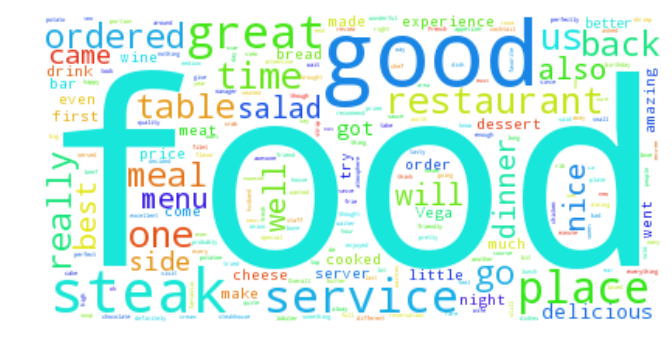

In [4]:
text = open('../../yelp-data/review_text.txt').read()
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [51]:
wordcloud.to_file("../../yelp-data/wordclouds/wc.png")

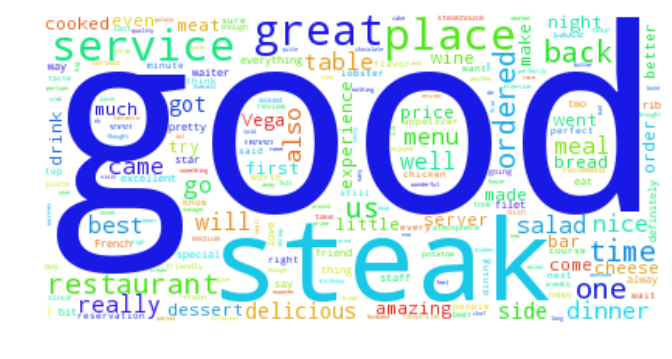

In [8]:
wordcloud = WordCloud(stopwords=STOPWORDS.add('food'),background_color='white', max_words=10000).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [9]:
wordcloud.to_file("../../yelp-data/wordclouds/wc2.png")

Words that we can look into: cheese, dessert, night, drink, side, dinner, salad, bar, cooked, meat, pretty . . . 

# How about most frequent words used / state?

In [10]:
# not looking at FIF MLN & NM (below 15 reviews)
text_AZ = data['text'][data.state == 'AZ']
text_AZ.values.tolist()
with open('../../yelp-data/text_AZ.txt','w') as file:
    for item in text_AZ:
        print>>file, item
        
text_BW = data['text'][data.state == 'BW']
text_BW.values.tolist()
with open('../../yelp-data/text_BW.txt','w') as file:
    for item in text_BW:
        print>>file, item
        
text_EDH = data['text'][data.state == 'EDH']
text_EDH.values.tolist()
with open('../../yelp-data/text_EDH.txt','w') as file:
    for item in text_EDH:
        print>>file, item
        
text_IL = data['text'][data.state == 'IL']
text_IL.values.tolist()
with open('../../yelp-data/text_IL.txt','w') as file:
    for item in text_IL:
        print>>file, item
        
text_NC = data['text'][data.state == 'NC']
text_NC.values.tolist()
with open('../../yelp-data/text_NC.txt','w') as file:
    for item in text_NC:
        print>>file, item
        
text_NV = data['text'][data.state == 'NV']
text_NV.values.tolist()
with open('../../yelp-data/text_NV.txt','w') as file:
    for item in text_NV:
        print>>file, item
        
text_ON = data['text'][data.state == 'ON']
text_ON.values.tolist()
with open('../../yelp-data/text_ON.txt','w') as file:
    for item in text_ON:
        print>>file, item
        
text_PA = data['text'][data.state == 'PA']
text_PA.values.tolist()
with open('../../yelp-data/text_PA.txt','w') as file:
    for item in text_PA:
        print>>file, item
        
text_QC = data['text'][data.state == 'QC']
text_QC.values.tolist()
with open('../../yelp-data/text_QC.txt','w') as file:
    for item in text_QC:
        print>>file, item
        
text_SC = data['text'][data.state == 'SC']
text_SC.values.tolist()
with open('../../yelp-data/text_SC.txt','w') as file:
    for item in text_SC:
        print>>file, item
        
text_TX = data['text'][data.state == 'TX']
text_TX.values.tolist()
with open('../../yelp-data/text_TX.txt','w') as file:
    for item in text_TX:
        print>>file, item
        
text_WI = data['text'][data.state == 'WI']
text_WI.values.tolist()
with open('../../yelp-data/text_WI.txt','w') as file:
    for item in text_WI:
        print>>file, item


In [13]:
text = open('../../yelp-data/text_AZ.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/AZ.png")

In [14]:
text = open('../../yelp-data/text_BW.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/BW.png")

In [15]:
text = open('../../yelp-data/text_EDH.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/EDH.png")

In [16]:
text = open('../../yelp-data/text_IL.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/IL.png")

In [17]:
text = open('../../yelp-data/text_NC.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/NC.png")

In [18]:
text = open('../../yelp-data/text_NV.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/NV.png")

In [19]:
text = open('../../yelp-data/text_ON.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/ON.png")

In [20]:
text = open('../../yelp-data/text_PA.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/PA.png")

In [21]:
text = open('../../yelp-data/text_QC.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/QC.png")

In [22]:
text = open('../../yelp-data/text_SC.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/SC.png")

In [23]:
text = open('../../yelp-data/text_TX.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/TX.png")

In [24]:
text = open('../../yelp-data/text_WI.txt').read()
wc = WordCloud(stopwords=STOPWORDS.add('food'),background_color="white", max_words=10000)
wc.generate(text)
wc.to_file("../../yelp-data/wordclouds/WI.png")

What words come to mind now? <b>cooked</b>, <b>overcooked</b>, rib, nice, <b>salad</b>, meat (TX!!), <b>bar</b>, <b>delicious</b>, <b>experience</b>, bread, <b>wine</b>, <b>special</b>, happy, <b>cheese</b>, <b>starter/appetizer</b>, <b>sauce</b> (EDH,ON!), <b>lovely</b>, <b>tasty</b>, <b>juicy</b> (?), little, <b>night</b>, <b>day</b>, definitely, <b>quite</b>, <b>fries / frites</b> (?), wait, <b>love</b>, birthday, service

In [7]:
data['overcooked'] = data['text'].str.contains('overcooked')
data['salad'] = data['text'].str.contains('salad')
data['bar'] = data['text'].str.contains('bar')
data['delicious'] = data['text'].str.contains('delicious')
data['experience'] = data['text'].str.contains('experience')
data['wine'] = data['text'].str.contains('wine')
data['special'] = data['text'].str.contains('special')
data['cheese'] = data['text'].str.contains('cheese')
data['lovely'] = data['text'].str.contains('lovely')
data['tasty'] = data['text'].str.contains('tasty')
data['juicy'] = data['text'].str.contains('juicy')
data['quite'] = data['text'].str.contains('quite')
data['fries'] = data['text'].str.contains('fries')
data['frites'] = data['text'].str.contains('frites')
data['entrecote'] = data['text'].str.contains('entrecote')
data['flavorless'] = data['text'].str.contains('flavorless')
data['sauce'] = data['text'].str.contains('sauce')

In [36]:
data.groupby(['state'],as_index=False).sauce.mean()

,state,sauce
0,AZ,0.086624
1,BW,0.056911
2,EDH,0.173154
3,FIF,0.333333
4,IL,0.066421
5,MLN,0.088235
6,NC,0.091408
7,NM,0.250000
8,NV,0.119867
9,ON,0.120253


In [34]:
data.groupby(['state'],as_index=False).flavorless.mean()

,state,flavorless
0,AZ,0.004988
1,BW,0.000000
2,EDH,0.000000
3,FIF,0.000000
4,IL,0.014760
5,MLN,0.000000
6,NC,0.004205
7,NM,0.000000
8,NV,0.005030
9,ON,0.000000


In [8]:
data.groupby(['state'],as_index=False).entrecote.mean()

,state,entrecote
0,AZ,0.000035
1,BW,0.000000
2,EDH,0.001342
3,FIF,0.000000
4,IL,0.000000
5,MLN,0.000000
6,NC,0.000000
7,NM,0.000000
8,NV,0.000048
9,ON,0.000000


In [41]:
data.groupby(['state'],as_index=False).special.mean()

,state,special
0,AZ,0.146199
1,BW,0.008130
2,EDH,0.205369
3,FIF,0.666667
4,IL,0.202952
5,MLN,0.147059
6,NC,0.183547
7,NM,0.000000
8,NV,0.159061
9,ON,0.183544


In [40]:
data.groupby(['state'],as_index=False).lovely.mean()

,state,lovely
0,AZ,0.016966
1,BW,0.000000
2,EDH,0.163758
3,FIF,0.000000
4,IL,0.018450
5,MLN,0.264706
6,NC,0.019561
7,NM,0.000000
8,NV,0.021755
9,ON,0.012658


In [39]:
data.groupby(['state'],as_index=False).quite.mean()

,state,quite
0,AZ,0.051075
1,BW,0.008130
2,EDH,0.158389
3,FIF,0.000000
4,IL,0.084871
5,MLN,0.205882
6,NC,0.055027
7,NM,0.083333
8,NV,0.060743
9,ON,0.120253


In [37]:
data.groupby(['state'],as_index=False).experience.mean()

,state,experience
0,AZ,0.171034
1,BW,0.000000
2,EDH,0.124832
3,FIF,0.666667
4,IL,0.180812
5,MLN,0.176471
6,NC,0.198720
7,NM,0.083333
8,NV,0.202856
9,ON,0.164557


In [36]:
data.groupby(['state'],as_index=False).delicious.mean()

,state,delicious
0,AZ,0.145953
1,BW,0.000000
2,EDH,0.264430
3,FIF,0.333333
4,IL,0.147601
5,MLN,0.294118
6,NC,0.157587
7,NM,0.000000
8,NV,0.195240
9,ON,0.221519


In [35]:
data.groupby(['state'],as_index=False).bar.mean()

,state,bar
0,AZ,0.194885
1,BW,0.243902
2,EDH,0.102013
3,FIF,0.666667
4,IL,0.309963
5,MLN,0.147059
6,NC,0.198537
7,NM,0.166667
8,NV,0.140654
9,ON,0.075949


In [34]:
data.groupby(['state'],as_index=False).salad.mean()

,state,salad
0,AZ,0.170051
1,BW,0.000000
2,EDH,0.148993
3,FIF,0.333333
4,IL,0.306273
5,MLN,0.029412
6,NC,0.222303
7,NM,0.000000
8,NV,0.157918
9,ON,0.082278


In [32]:
data.groupby(['state'],as_index=False).cheese.mean()

,state,cheese
0,AZ,0.108402
1,BW,0.000000
2,EDH,0.190604
3,FIF,0.333333
4,IL,0.118081
5,MLN,0.294118
6,NC,0.157221
7,NM,0.083333
8,NV,0.128102
9,ON,0.145570


In [33]:
data.groupby(['state'],as_index=False).wine.mean()

,state,wine
0,AZ,0.103485
1,BW,0.000000
2,EDH,0.283221
3,FIF,0.666667
4,IL,0.136531
5,MLN,0.235294
6,NC,0.155210
7,NM,0.083333
8,NV,0.140955
9,ON,0.158228


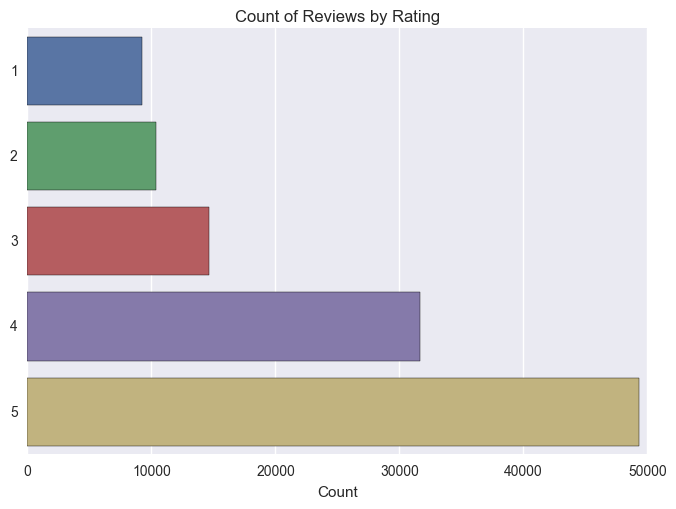

In [9]:
sns.countplot(y='stars', data=data)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Count of Reviews by Rating')

In [10]:
data.groupby(['stars'],as_index=False).entrecote.mean()

,stars,entrecote
0,1,0.000109
1,2,0.000193
2,3,0.000137
3,4,0.000095
4,5,0.000061


In [11]:
data.groupby(['stars'],as_index=False).special.mean()

,stars,special
0,1,0.111811
1,2,0.159896
2,3,0.181128
3,4,0.162988
4,5,0.147488


In [14]:
data.groupby(['stars'],as_index=False).lovely.mean()

,stars,lovely
0,1,0.007715
1,2,0.013992
2,3,0.018818
3,4,0.028809
4,5,0.025055


In [15]:
data.groupby(['stars'],as_index=False).quite.mean()

,stars,quite
0,1,0.040530
1,2,0.067162
2,3,0.089914
3,4,0.077667
4,5,0.043902


In [16]:
data.groupby(['stars'],as_index=False).experience.mean()

,stars,experience
0,1,0.219494
1,2,0.213259
2,3,0.169153
3,4,0.159731
4,5,0.198349


In [17]:
data.groupby(['stars'],as_index=False).delicious.mean() 
# wtf are the folks talking about in 1 star rating?! the ones who mention the word, delicious at least

,stars,delicious
0,1,0.028143
1,2,0.071890
2,3,0.126796
3,4,0.213174
4,5,0.225026


In [24]:
data_delicious = data['text'][(data.delicious == True) & (data.stars == 1)]

In [29]:
len(data_delicious)

259

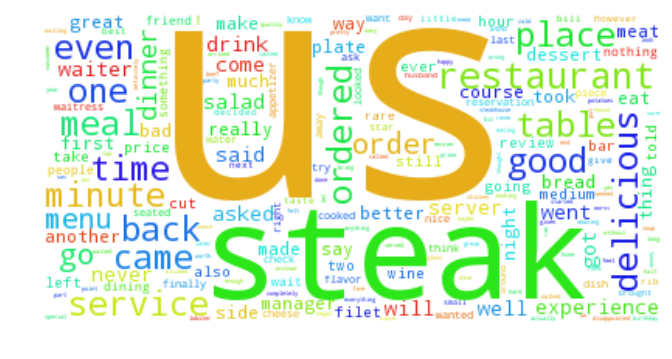

In [32]:
data_delicious.values.tolist()
with open('../../yelp-data/delicious_text.txt','w') as file:
    for item in data_delicious:
        print>>file, item
text = open('../../yelp-data/delicious_text.txt').read()
wordcloud = WordCloud(stopwords=STOPWORDS.add("food"),background_color='white').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

After taking a peek at the text file, it seems like either food was flavorless (why take out all that deliciousness? overcooked steak), bad experience (but good food), small portions, delicious when you dine in but sucks when you order in, long wait, hoping for something "delicious", other restaurant more delicious that this "hell hole"...

In [37]:
data.groupby(['stars'],as_index=False).bar.mean()

,stars,bar
0,1,0.188743
1,2,0.194249
2,3,0.174080
3,4,0.169660
4,5,0.141402


In [38]:
data.groupby(['stars'],as_index=False).salad.mean()

,stars,salad
0,1,0.140063
1,2,0.183055
2,3,0.187286
3,4,0.189235
4,5,0.148300


In [39]:
data.groupby(['stars'],as_index=False).cheese.mean()

,stars,cheese
0,1,0.070086
1,2,0.108366
2,3,0.134460
3,4,0.144172
4,5,0.122839


In [40]:
data.groupby(['stars'],as_index=False).wine.mean()

,stars,wine
0,1,0.084320
1,2,0.122744
2,3,0.116737
3,4,0.145057
4,5,0.141950


In [41]:
data.groupby(['stars'],as_index=False).sauce.mean()

,stars,sauce
0,1,0.066717
1,2,0.109042
2,3,0.126317
3,4,0.122699
4,5,0.101599


In [42]:
data.groupby(['stars'],as_index=False).flavorless.mean()

,stars,flavorless
0,1,0.015321
1,2,0.021422
2,3,0.008417
3,4,0.001423
4,5,0.000365


## How about the steak subset?

In [43]:
steak_subset = pd.read_csv('../../yelp-data/steak_subset.csv')

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,7,18,19,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


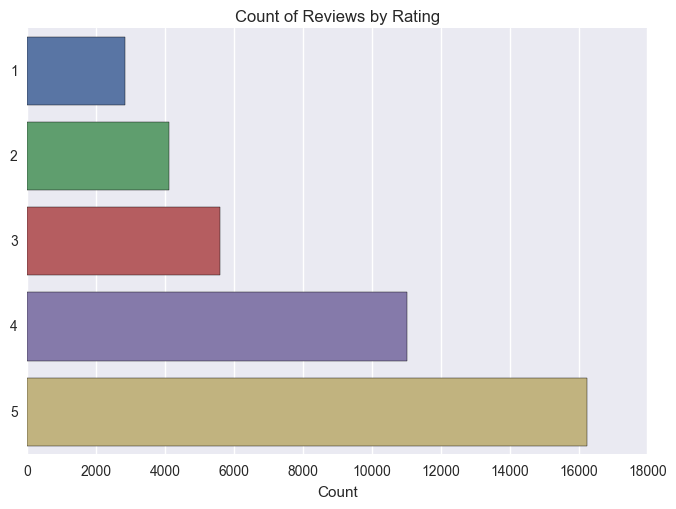

In [44]:
sns.countplot(y='stars', data=steak_subset)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Count of Reviews by Rating')

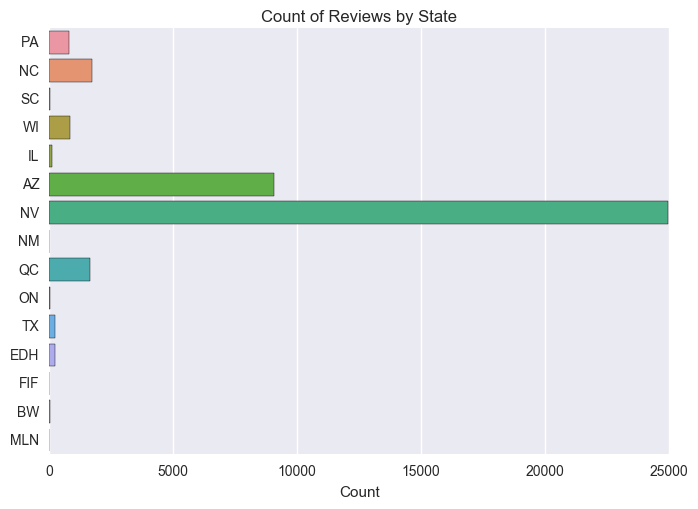

In [45]:
sns.countplot(y='state', data=steak_subset)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Count of Reviews by State')

In [46]:
reviews = steak_subset['text']
reviews.values.tolist()
with open('../../yelp-data/steak_review_text.txt','w') as file:
    for item in reviews:
        print>>file, item

In [53]:
stopwords = set(STOPWORDS)
stopwords.add("steak")

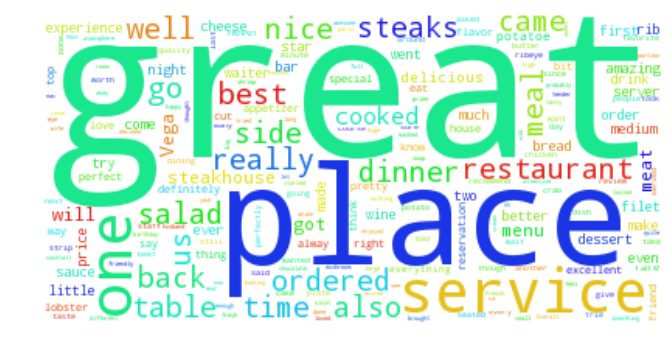

In [54]:
text = open('../../yelp-data/steak_review_text.txt').read()
wordcloud = WordCloud(stopwords=STOPWORDS.add("good"),background_color='white').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()